In [1]:
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import entropy
from tqdm import tqdm
import torch


from vla_calibration.utils import *
from vla_calibration.calibration import *

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def recal_experiment(
    action_conf, 
    action_logits,
    correct, 
    test_size=0.4,
    n_trials = 100,
    n_cal_bins = 10
):
    
    uncal_eces = []
    recal_eces = []
    action_recal_eces = []
    temp_scale_eces = []
    
    for trial_no in tqdm(range(n_trials)):

        conf_train, conf_test, logits_train, logits_test, correct_train, correct_test \
              = train_test_split_three_way(action_conf, action_logits, correct, test_size=test_size, random_state=trial_no)
        
        mean_train_conf = np.mean(conf_train, -1)
        mean_test_conf = np.mean(conf_test, -1)

        uncal_ece = round(get_ece(mean_test_conf, correct_test, n_cal_bins), 3)

        scaler = PlattScaler(max_iter=200, tol=1e-6)
        scaler.fit(mean_train_conf, correct_train)

        calibrated_probs = scaler.predict(mean_test_conf)

        recal_ece = round(get_ece(calibrated_probs, correct_test, n_cal_bins), 3)

        action_scaler = ActionPlattScaler(max_iter=200, tol=1e-8, combine_method="mean")
        action_scaler.fit(conf_train, correct_train)

        calibrated_probs = action_scaler.predict(conf_test)

        action_recal_ece = round(get_ece(calibrated_probs, correct_test, n_cal_bins), 3)

        temp_scaler = TempScaler()
        temp_scaler.set_temperature(torch.Tensor(logits_train), torch.FloatTensor(correct_train))
        temp_scaler.eval()
        with torch.no_grad():
            scaled_test_conf = temp_scaler.temperature_scale(torch.Tensor(logits_test).cuda()).cpu().numpy()
        temp_scale_ece = round(get_ece(scaled_test_conf, correct_test, n_cal_bins), 3)


        uncal_eces.append(uncal_ece)
        recal_eces.append(recal_ece)
        action_recal_eces.append(action_recal_ece)

        temp_scale_eces.append(temp_scale_ece)
        

    print(f"uncal ece: {np.mean(uncal_eces)} | recal ece: {np.mean(recal_eces)} | action recal ece: {np.mean(action_recal_eces)}")
    print(f"temp scale ece: {np.mean(temp_scale_eces)}")
    return {
        "uncal_ece": np.mean(uncal_eces), "recal_ece": np.mean(recal_eces), "action_recal_ece": np.mean(action_recal_eces),
        "temp_scale_ece": np.mean(temp_scale_eces),
        "recal_ece_std": np.std(recal_eces), "action_recal_ece_std": np.std(action_recal_eces),
        "temp_scale_std": np.std(temp_scale_eces),
        }




In [3]:
def run_exp(task_name, quant, n_bins=12, test_size=0.8, n_prompts=20, n_trials=1000, alternate_set=1):


    base_probs, _, base_logits, _, correct, by_dim_results = get_scaling_data(
        task_name, 
        alternate_set=alternate_set, 
        n_prompts=n_prompts,
        quant=quant,
    )

    base_conf = np.mean(np.max(base_probs, -1), -2)[:,0]

    print("---------------------\nBase Recalibration")
    baseline_results = recal_experiment(
        base_conf, 
        base_logits[:,0,0],
        correct, 
        test_size=test_size,
        n_trials=n_trials,
        n_cal_bins=n_bins,
    )
    print(baseline_results)

    bar_colors = pal[1:4]
    scale_factor = 1.25

    fig, axs = plt.subplots(1,2, figsize=(10, 3.25), width_ratios=[0.45,0.55])

    scores = by_dim_results["baseline"]
    X = np.arange(len(scores))
    axs[0].bar(X, scores)
    labels = [f"{i+1}" for i in range(len(by_dim_results["baseline"]))]
    axs[0].set_xticks(X, labels, fontsize=15)
    axs[0].set_xlabel("Action Dimension", fontsize=18)

    scores = [baseline_results["temp_scale_ece"], baseline_results["recal_ece"], baseline_results["action_recal_ece"]]
    stds = [baseline_results["temp_scale_std"], baseline_results["recal_ece_std"], baseline_results["action_recal_ece_std"]]
    labels = ["Temp\nScaling","Platt\nScaling","Action-Wise\nPlatt Scaling"]
    X = np.arange(len(scores))
    axs[1].bar(X, scores, color=bar_colors, yerr=stds/np.sqrt(n_trials), error_kw=dict(ecolor='dimgrey', lw=2, capsize=3, capthick=2))
    axs[1].set_xticks(X, labels, fontsize=15)

    for i in range(2):
        axs[i].set_ylabel(r"$\text{ECE}_1$", fontsize=18)
        axs[i].tick_params(axis="y", labelsize=13)

    if quant is not None:
        quant_tag = f" ({quant})"
    else:
        quant_tag = ""

    axs[1].set_ylim(min(baseline_results["recal_ece"], baseline_results["action_recal_ece"])/scale_factor, None)

    fig.suptitle(f"{str.title(task_name)}{str.title(quant_tag)}", fontsize=18, y=0.95)
    fig.tight_layout()

    quant_save_string = quant_tag.replace("(","").replace(")","").strip()

    plt.savefig(f"../plots/action_scaling_{task_name}_{quant_save_string}_baseline_w_temp_scaling.png", dpi=600, bbox_inches="tight")
    plt.show()


[load_or_create_pickle] Loading existing pickle: /local/zemel/tom/code/vla_calibration/data/scaling_exp_spatial.pkl
---------------------
Base Recalibration


100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


uncal ece: 0.087 | recal ece: 0.063 | action recal ece: 0.039
temp scale ece: 0.0835
{'uncal_ece': 0.087, 'recal_ece': 0.063, 'action_recal_ece': 0.039, 'temp_scale_ece': 0.0835, 'recal_ece_std': 0.006000000000000002, 'action_recal_ece_std': 0.008, 'temp_scale_std': 0.0005000000000000004}


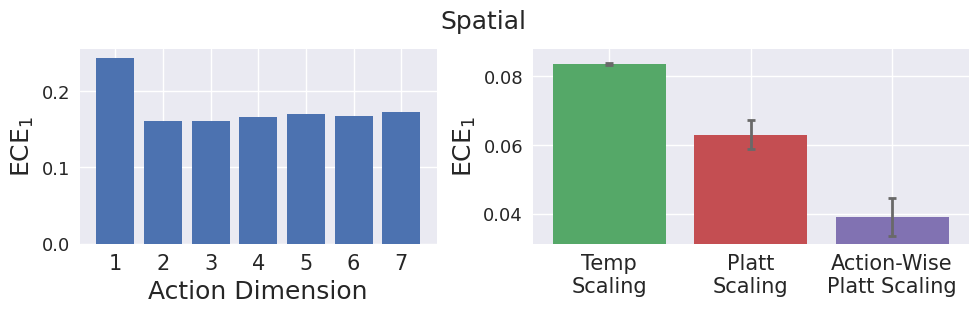

[load_or_create_pickle] Loading existing pickle: /local/zemel/tom/code/vla_calibration/data/scaling_exp_goal.pkl
---------------------
Base Recalibration


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


uncal ece: 0.14950000000000002 | recal ece: 0.068 | action recal ece: 0.0605
temp scale ece: 0.1135
{'uncal_ece': 0.14950000000000002, 'recal_ece': 0.068, 'action_recal_ece': 0.0605, 'temp_scale_ece': 0.1135, 'recal_ece_std': 0.009999999999999998, 'action_recal_ece_std': 0.005500000000000001, 'temp_scale_std': 0.013499999999999998}


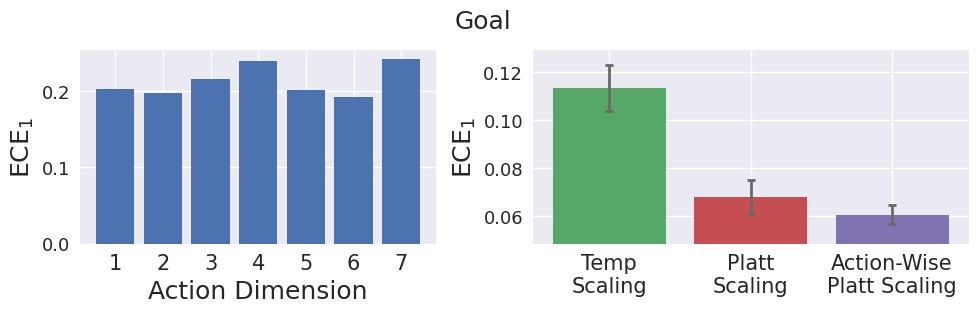

In [4]:
n_bins = 10
test_size = 0.8
n_trials = 2


run_exp("spatial", quant=None, n_bins=n_bins, test_size=test_size, n_trials=n_trials)
run_exp("goal", quant=None, n_bins=n_bins, test_size=test_size, n_trials=n_trials)


[load_or_create_pickle] Loading existing pickle: /local/zemel/tom/code/vla_calibration/data/scaling_exp_spatial_quant8.pkl
---------------------
Base Recalibration


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


uncal ece: 0.0785 | recal ece: 0.076 | action recal ece: 0.0755
temp scale ece: 0.066
{'uncal_ece': 0.0785, 'recal_ece': 0.076, 'action_recal_ece': 0.0755, 'temp_scale_ece': 0.066, 'recal_ece_std': 0.032, 'action_recal_ece_std': 0.0315, 'temp_scale_std': 0.006999999999999999}


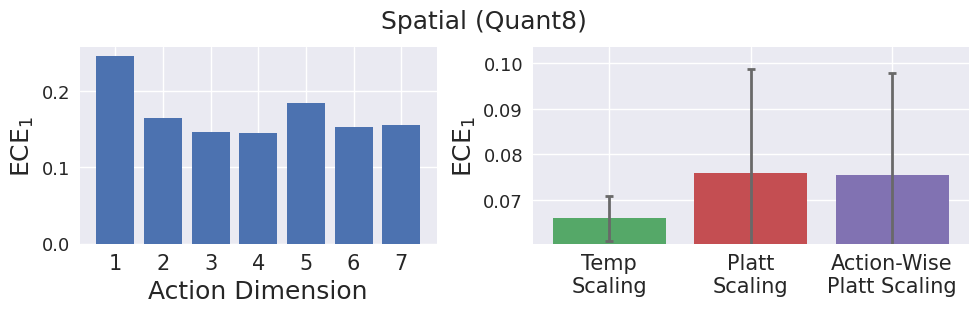

[load_or_create_pickle] Loading existing pickle: /local/zemel/tom/code/vla_calibration/data/scaling_exp_goal_quant8.pkl
---------------------
Base Recalibration


100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


uncal ece: 0.147 | recal ece: 0.07 | action recal ece: 0.064
temp scale ece: 0.125
{'uncal_ece': 0.147, 'recal_ece': 0.07, 'action_recal_ece': 0.064, 'temp_scale_ece': 0.125, 'recal_ece_std': 0.005999999999999998, 'action_recal_ece_std': 0.013000000000000001, 'temp_scale_std': 0.006000000000000005}


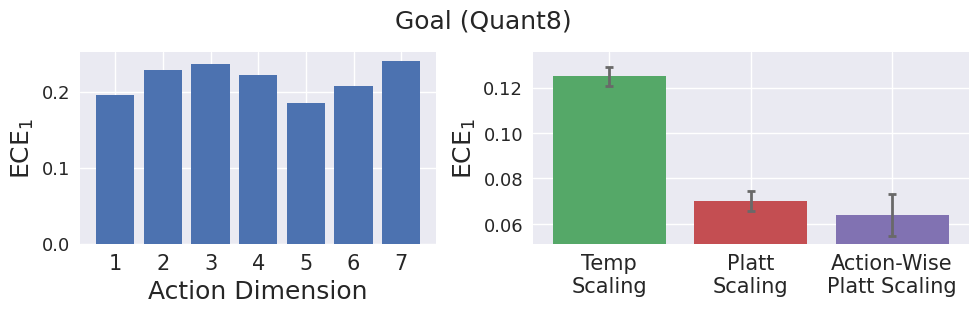

In [5]:
run_exp("spatial", quant="quant8", n_bins=n_bins, test_size=test_size, n_trials=n_trials)
run_exp("goal", quant="quant8", n_bins=n_bins, test_size=test_size, n_trials=n_trials)


[load_or_create_pickle] Loading existing pickle: /local/zemel/tom/code/vla_calibration/data/scaling_exp_spatial_quant4.pkl
---------------------
Base Recalibration


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


uncal ece: 0.076 | recal ece: 0.077 | action recal ece: 0.068
temp scale ece: 0.077
{'uncal_ece': 0.076, 'recal_ece': 0.077, 'action_recal_ece': 0.068, 'temp_scale_ece': 0.077, 'recal_ece_std': 0.010999999999999996, 'action_recal_ece_std': 0.0010000000000000009, 'temp_scale_std': 0.015}


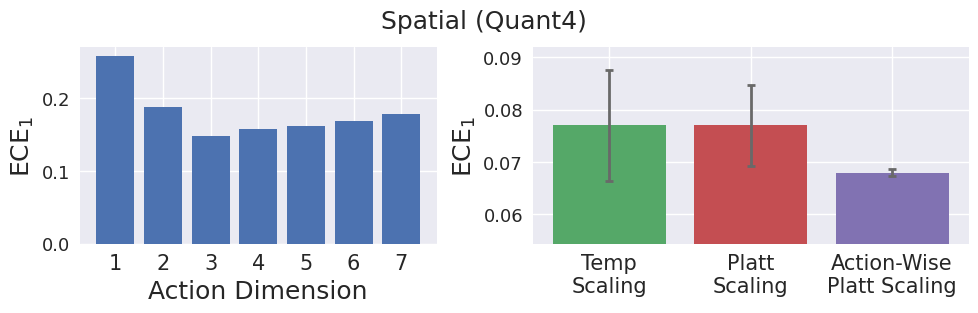

[load_or_create_pickle] Loading existing pickle: /local/zemel/tom/code/vla_calibration/data/scaling_exp_goal_quant4.pkl
---------------------
Base Recalibration


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


uncal ece: 0.183 | recal ece: 0.1205 | action recal ece: 0.10350000000000001
temp scale ece: 0.11599999999999999
{'uncal_ece': 0.183, 'recal_ece': 0.1205, 'action_recal_ece': 0.10350000000000001, 'temp_scale_ece': 0.11599999999999999, 'recal_ece_std': 0.009500000000000001, 'action_recal_ece_std': 0.0085, 'temp_scale_std': 0.005999999999999998}


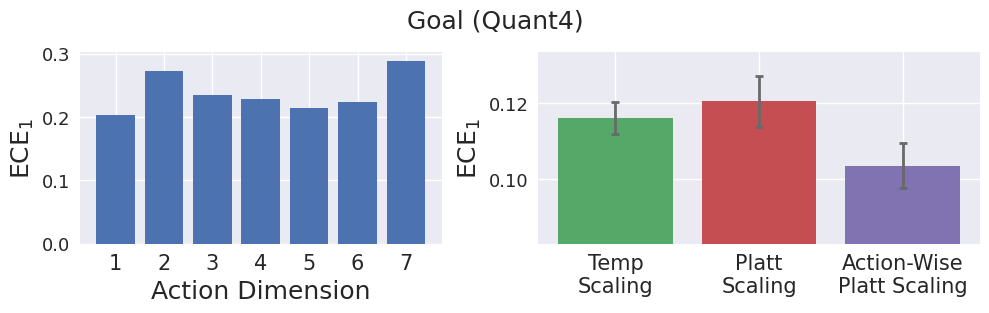

In [6]:
run_exp("spatial", quant="quant4", n_bins=n_bins, test_size=test_size, n_trials=n_trials)
run_exp("goal", quant="quant4", n_bins=n_bins, test_size=test_size, n_trials=n_trials)
